# 4-6 DDPG ~ Pendulum-v0 ~

In [1]:
#TensorFlowがGPUを認識しているか確認
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-11-24 17:17:01.017158: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-11-24 17:17:01.062820: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2022-11-24 17:17:01.067583: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55cca65abb30 executing computations on platform Host. Devices:
2022-11-24 17:17:01.067608: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-11-24 17:17:01.069778: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2022-11-24 17:17:01.456879: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55cca78e7e70 executing computations on platform CUDA. Devices:
2022-11-24 17:17:01.456907: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Tesla V100-PC

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14310783457566685841,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9374080955152185437
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1265245493500813322
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:1"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16450090722188075055
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:2"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13435951229597802006
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:3"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14347010350727466981
 physical_device_desc: "device: XLA_GPU device"

## Pendulum-v0
壁にぶら下がったバーにうまく力を加えて直立させることを目指すPendulum-v0
- 状態: 座標x, yと角速度
  - 座標 (x, y): それぞれ$\cos \theta, \sin \theta$として与えられる. x, y共に[-1, 1]の範囲.
    - 座標はおそらくバーの先端 
  - 角速度: [-8, 8]らしい (この辺り調査不足)
- 行動: こちらが干渉できるのは左方向もしくは右方向に力を与えること [-2, 2]で表現できるとのこと

=> とりあえずバーを直立にさせるのが目標٩( ᐛ )و

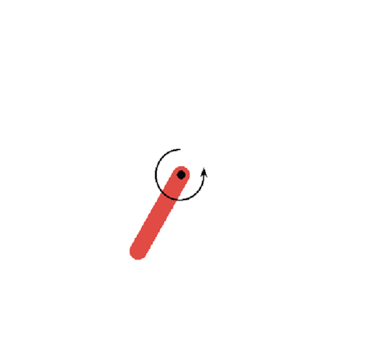

[参考](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py)

In [3]:
import numpy as np
import gym

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, Concatenate
from keras.optimizers import Adam

import sys
sys.path.append("../src/")
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

ENV_NAME = 'Pendulum-v0'
#gym.undo_logger_setup() # ナニコレ

In [4]:
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

In [5]:
# Next, we build a very simple model.
actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('linear'))
print(actor.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_3 (Activation)    (None, 16)               

In [6]:
action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  (None, 1, 3)         0                                            
__________________________________________________________________________________________________
action_input (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3)            0           observation_input[0][0]          
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 4)            0           action_input[0][0]               
                                                                 flatten_2[0][0]            

In [7]:
# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])

2022-11-24 17:19:36.726117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 0 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:3d:00.0
2022-11-24 17:19:36.727201: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 1 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:3e:00.0
2022-11-24 17:19:36.728262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 2 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:88:00.0
2022-11-24 17:19:36.729294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 3 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:89:00.0
2022-11-24 17:19:36.729438: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Could not dlopen library 'libcudart.so.10.0'; dlerror: l

学習

In [8]:
# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
agent.fit(env, nb_steps=50000, visualize=False, verbose=1, nb_max_episode_steps=200)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 36s 4ms/step - reward: -6.5810
50 episodes - episode_reward: -1316.193 [-1856.447, -865.584] - loss: 2.607 - mae: 0.483 - mean_q: -32.144

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 35s 4ms/step - reward: -2.2845
50 episodes - episode_reward: -456.898 [-1491.342, -0.896] - loss: 12.235 - mae: 0.934 - mean_q: -66.029

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 35s 4ms/step - reward: -0.8829
50 episodes - episode_reward: -176.588 [-381.481, -3.564] - loss: 15.355 - mae: 1.087 - mean_q: -61.434

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 36s 4ms/step - reward: -0.6799
50 episodes - episode_reward: -135.982 [-343.401, -4.342] - loss: 14.956 - mae: 1.207 - mean_q: -50.748

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 36s 4ms/step - re

In [9]:
# After training is done, we save the final weights.
agent.save_weights('ddpg_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
#Finally, evaluate our algorithm for 5 episodes.
agent.test(env, nb_episodes=5, visualize=True, nb_max_episode_steps=200)

Testing for 5 episodes ...
Episode 1: reward: -242.220, steps: 200
Episode 2: reward: -123.277, steps: 200
Episode 3: reward: -248.347, steps: 200
Episode 4: reward: -243.268, steps: 200
Episode 5: reward: -115.946, steps: 200


可視化させるにはrl.callbackのvisualizerクラスをoverwrideする必要あり